# Multi-Layer Perceptron, CNN on GPU
---
In this notebook, we will train a CNN to classify images from the [MNIST database](http://yann.lecun.com/exdb/mnist/) hand-written digit database.

The process will be broken down into the following steps:
>1. Load and visualize the data
2. Define a neural network
3. Train the model
4. Evaluate the performance of our trained model on a test dataset!

Before we begin, we have to import the necessary libraries for working with data and PyTorch.

In [19]:
# import libraries
import torch
import numpy as np
from time import time


# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


---
## Load and Visualize the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Downloading may take a few moments, and you should see your progress as the data is loading. You may also choose to change the `batch_size` if you want to load more data at a time.

This cell will create DataLoaders for each of our datasets.

In [22]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler



# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2


# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]


# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

### Visualize a Batch of Training Data

The first step in a classification task is to take a look at the data, make sure it is loaded in correctly, then make any initial observations about patterns in that data.

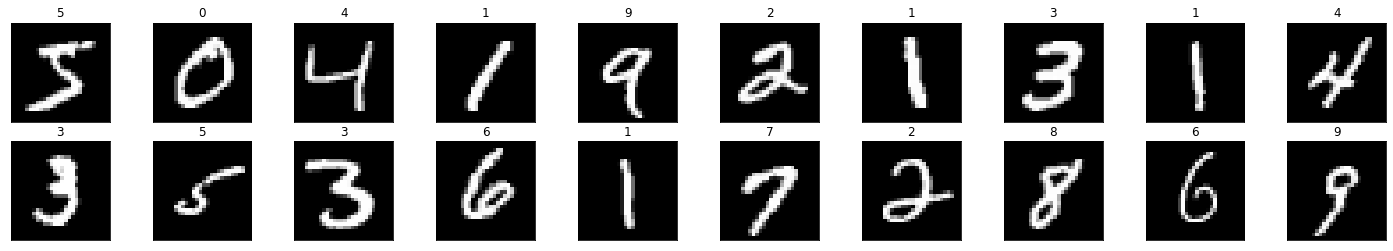

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

In [24]:
#20 immagini, 1 colore, 28x28
images.shape


(20, 1, 28, 28)

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

The architecture will be responsible for seeing as input a 784-dim Tensor of pixel values for each image, and producing a Tensor of length 10 (our number of classes) that indicates the class scores for an input image. This particular example uses two hidden layers and dropout to avoid overfitting.

## Convolutional Layers in PyTorch

To create a convolutional layer in PyTorch, you must first import the necessary module:

import torch.nn as nn

Then, there is a two part process to defining a convolutional layer and defining the feedforward behavior of a model (how an input moves through the layers of a network). First, you must define a Model class and fill in two functions.

### init

You can define a convolutional layer in the __init__ function of by using the following format:

self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)

### forward

Then, you refer to that layer in the forward function! Here, I am passing in an input image x and applying a ReLU function to the output of this layer.

x = F.relu(self.conv1(x))

### Arguments

You must pass the following arguments:

    in_channels - The number of inputs (in depth), 3 for an RGB image, for example.
    out_channels - The number of output channels, i.e. the number of filtered "images" a convolutional layer is made of or the number of unique, convolutional kernels that will be applied to an input.
    kernel_size - Number specifying both the height and width of the (square) convolutional kernel.

There are some additional, optional arguments that you might like to tune:

    stride - The stride of the convolution. If you don't specify anything, stride is set to 1.
    padding - The border of 0's around an input array. If you don't specify anything, padding is set to 0.

NOTE: It is possible to represent both kernel_size and stride as either a number or a tuple.

There are many other tunable arguments that you can set to change the behavior of your convolutional layers. To read more about these, we recommend perusing the official documentation.

## Pooling Layers

Pooling layers take in a kernel_size and a stride. Typically the same value as is the down-sampling factor. For example, the following code will down-sample an input's x-y dimensions, by a factor of 2:

self.pool = nn.MaxPool2d(2,2)

### forward

Here, we see that poling layer being applied in the forward function.

x = F.relu(self.conv1(x))
x = self.pool(x)

### Convolutional Example #1

Say I'm constructing a CNN, and my input layer accepts grayscale images that are 200 by 200 pixels (corresponding to a 3D array with height 200, width 200, and depth 1). Then, say I'd like the next layer to be a convolutional layer with 16 filters, each filter having a width and height of 2. When performing the convolution, I'd like the filter to jump two pixels at a time. I also don't want the filter to extend outside of the image boundaries; in other words, I don't want to pad the image with zeros. Then, to construct this convolutional layer, I would use the following line of code:

self.conv1 = nn.Conv2d(1, 16, 2, stride=2)

### Convolutional Example #2

Say I'd like the next layer in my CNN to be a convolutional layer that takes the layer constructed in Example 1 as input. Say I'd like my new layer to have 32 filters, each with a height and width of 3. When performing the convolution, I'd like the filter to jump 1 pixel at a time. I want this layer to have the same width and height as the input layer, and so I will pad accordingly. Then, to construct this convolutional layer, I would use the following line of code:

self.conv2 = nn.Conv2d(16, 32, 3, padding=1)

Convolution with 3x3 window and stride 1

Image source: http://iamaaditya.github.io/2016/03/one-by-one-convolution/


## Sequential Models

We can also create a CNN in PyTorch by using a Sequential wrapper in the __init__ function. Sequential allows us to stack different types of layers, specifying activation functions in between!

def __init__(self):
        super(ModelName, self).__init__()
        self.features = nn.Sequential(
              nn.Conv2d(1, 16, 2, stride=2),
              nn.MaxPool2d(2, 2),
              nn.ReLU(True),

              nn.Conv2d(16, 32, 3, padding=1),
              nn.MaxPool2d(2, 2),
              nn.ReLU(True) 
         )



## Formula: Number of Parameters in a Convolutional Layer

The number of parameters in a convolutional layer depends on the supplied values of filters/out_channels, kernel_size, and input_shape. Let's define a few variables:

    K - the number of filters in the convolutional layer
    F - the height and width of the convolutional filters
    D_in - the depth of the previous layer

Notice that K = out_channels, and F = kernel_size. Likewise, D_in is the last value in the input_shape tuple, typically 1 or 3 (RGB and grayscale, respectively).

Since there are F*F*D_in weights per filter, and the convolutional layer is composed of K filters, the total number of weights in the convolutional layer is K*F*F*D_in. Since there is one bias term per filter, the convolutional layer has K biases. Thus, the number of parameters in the convolutional layer is given by K*F*F*D_in + K.

### Formula: Shape of a Convolutional Layer

The shape of a convolutional layer depends on the supplied values of kernel_size, input_shape, padding, and stride. Let's define a few variables:

    K - the number of filters in the convolutional layer
    F - the height and width of the convolutional filters
    S - the stride of the convolution
    P - the padding
    W_in - the width/height (square) of the previous layer

Notice that K = out_channels, F = kernel_size, and S = stride. Likewise, W_in is the first and second value of the input_shape tuple.

The depth of the convolutional layer will always equal the number of filters K.

The spatial dimensions of a convolutional layer can be calculated as: (W_in−F+2P)/S+1

### Flattening

Part of completing a CNN architecture, is to flatten the eventual output of a series of convolutional and pooling layers, so that all parameters can be seen (as a vector) by a linear classification layer. At this step, it is imperative that you know exactly how many parameters are output by a layer.

For the following quiz questions, consider an input image that is 130x130 (x, y) and 3 in depth (RGB). Say, this image goes through the following layers in order:

nn.Conv2d(3, 10, 3)
nn.MaxPool2d(4, 4)
nn.Conv2d(10, 20, 5, padding=2)
nn.MaxPool2d(2, 2)


### Calculate the Output Size of Conv. Layer

Say, we want to convolve a 28 X 28 image with a 5 X 5 kernel with a stride length of 1. What's the final size of the output?

Before going to the equation, let's lay down some definitions:

    the image is of size n X n
    the kernel is of size k X k
    the padding is of size p
    the stride is of length s

    The output size will be:

    ⌊ ((n+2p−k)/s)+1 ⌋×⌊ ((n+2p−k)/s)+1 ⌋

    Note: Should the fraction not be an integer, we'll have to round it down.

And since:

    n = 28
    k = 5
    p = 3
    s = 1

This give us 28 X 28 because:

CONV1: ⌊((28+2*2−5)/1)+1⌋×⌊((28+2*2−5)/1)+1⌋=28x28
PADDING: (28X28)/2 = 14x14
CONV2: ⌊((14+2*0−5)/1)+1⌋×⌊((14+2*0−5)/1)+1⌋=10x10
PADDING: (10x10)/2 = 5x5

In [58]:
import torch.nn as nn
import torch.nn.functional as F

# Defining the network (LeNet-5)  
class LeNet5(torch.nn.Module):          
     
    def __init__(self):     
        super(LeNet5, self).__init__()
        # Convolution (In LeNet-5, 32x32x1 images are given as input. Hence padding of 2 is done below)
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2, bias=True)
        # Max-pooling
        self.max_pool_1 = torch.nn.MaxPool2d(kernel_size=2)
        # Convolution
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0, bias=True)
        # Max-pooling
        self.max_pool_2 = torch.nn.MaxPool2d(kernel_size=2) 
        # Fully connected layer
        
        #CONV1: ⌊((28+2*2−5)/1)+1⌋×⌊((28+2*2−5)/1)+1⌋=28x28
        #PADDING: (28X28)/2 = 14x14
        #CONV2: ⌊((14+2*0−5)/1)+1⌋×⌊((14+2*0−5)/1)+1⌋=10x10
        #PADDING: (10x10)/2 = 5x5
        
        
        self.fc1 = torch.nn.Linear(16*5*5, 120)   # convert matrix with 16*5*5 (= 400) features to a matrix of 120 features (columns)
        self.fc2 = torch.nn.Linear(120, 84)       # convert matrix with 120 features to a matrix of 84 features (columns)
        self.fc3 = torch.nn.Linear(84, 10)        # convert matrix with 84 features to a matrix of 10 features (columns)
        
    def forward(self, x):
        # convolve, then perform ReLU non-linearity
        x = torch.nn.functional.relu(self.conv1(x))  
        # max-pooling with 2x2 grid 
        x = self.max_pool_1(x) 
        # convolve, then perform ReLU non-linearity
        x = torch.nn.functional.relu(self.conv2(x))
        # max-pooling with 2x2 grid
        x = self.max_pool_2(x)
        # first flatten 'max_pool_2_out' to contain 16*5*5 columns
        # read through https://stackoverflow.com/a/42482819/7551231
        x = x.view(-1, 16*5*5)
        # FC-1, then perform ReLU non-linearity
        x = torch.nn.functional.relu(self.fc1(x))
        # FC-2, then perform ReLU non-linearity
        x = torch.nn.functional.relu(self.fc2(x))
        # FC-3
        x = self.fc3(x)
        
        return x

# initialize the NN    
model = LeNet5()     

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

###  Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

It's recommended that you use cross-entropy loss for classification. If you look at the documentation (linked above), you can see that PyTorch's cross entropy function applies a softmax funtion to the output layer *and* then calculates the log loss.

In [59]:
# set up loss function -- 'SVM Loss' a.k.a 'Cross-Entropy Loss'
criterion = torch.nn.CrossEntropyLoss()
       
# SGD used for optimization, momentum update used as parameter update  
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)

---
## Train the Network

The steps for training/learning from a batch of data are described in the comments below:
1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss

The following loop trains for 30 epochs; feel free to change this number. For now, we suggest somewhere between 20-50 epochs. As you train, take a look at how the values for the training loss decrease over time. We want it to decrease while also avoiding overfitting the training data. 

In [60]:
time0 = time()

# number of epochs to train the model
n_epochs = 20  # suggest training between 20-50 epochs

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

#crea il dizionario per il plot
losses = {'train':[], 'validation':[]}

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data, target in train_loader:
 
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
 
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
      
        
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data, target in valid_loader:
        
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()        
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)
        
        
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
            
    #genera il vettore  per il plot
    losses['train'].append(train_loss)
    losses['validation'].append(valid_loss)        
  
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    print("Training Time (in minutes) =",(time()-time0)/60) 
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss
        


Epoch: 1 	Training Loss: 1.255873 	Validation Loss: 0.268438
Training Time (in minutes) = 0.3376912593841553
Validation loss decreased (inf --> 0.268438).  Saving model ...
Epoch: 2 	Training Loss: 0.166345 	Validation Loss: 0.144069
Training Time (in minutes) = 0.6651127974192301
Validation loss decreased (0.268438 --> 0.144069).  Saving model ...
Epoch: 3 	Training Loss: 0.098322 	Validation Loss: 0.096899
Training Time (in minutes) = 1.0096367041269938
Validation loss decreased (0.144069 --> 0.096899).  Saving model ...
Epoch: 4 	Training Loss: 0.074203 	Validation Loss: 0.087558
Training Time (in minutes) = 1.338044520219167
Validation loss decreased (0.096899 --> 0.087558).  Saving model ...
Epoch: 5 	Training Loss: 0.060822 	Validation Loss: 0.073624
Training Time (in minutes) = 1.6688329736391703
Validation loss decreased (0.087558 --> 0.073624).  Saving model ...
Epoch: 6 	Training Loss: 0.051823 	Validation Loss: 0.059199
Training Time (in minutes) = 2.0046737591425576
Validat

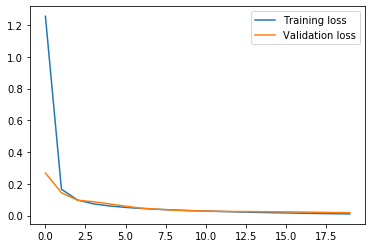

In [61]:
###Plot Train vs. validation

plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

###  Load the Model with the Lowest Validation Loss

In [62]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

---
## Test the Trained Network

Finally, we test our best model on previously unseen **test data** and evaluate it's performance. Testing on unseen data is a good way to check that our model generalizes well. It may also be useful to be granular in this analysis and take a look at how this model performs on each class as well as looking at its overall loss and accuracy.

In [63]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for *evaluation*

for data, target in test_loader:

    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()

    
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.047616

Test Accuracy of     0: 99% (978/980)
Test Accuracy of     1: 99% (1128/1135)
Test Accuracy of     2: 99% (1029/1032)
Test Accuracy of     3: 99% (1006/1010)
Test Accuracy of     4: 98% (970/982)
Test Accuracy of     5: 98% (877/892)
Test Accuracy of     6: 96% (929/958)
Test Accuracy of     7: 98% (1011/1028)
Test Accuracy of     8: 97% (954/974)
Test Accuracy of     9: 97% (982/1009)

Test Accuracy (Overall): 98% (9864/10000)


### Visualize Sample Test Results

This cell displays test images and their labels in this format: `predicted (ground-truth)`. The text will be green for accurately classified examples and red for incorrect predictions.

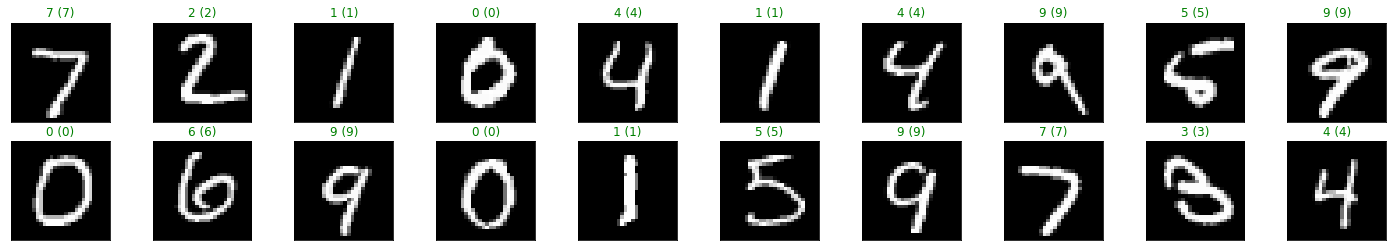

In [35]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()


# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()


# get sample outputs
output = model(images)

# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
preds = np.squeeze(preds.numpy()) if not train_on_gpu else np.squeeze(preds.cpu().numpy())


# prep images for display
images = images.cpu()#riporto images in CPU
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))